In [6]:
import numpy as np

x = np.arange(5)
y = np.arange(8)

z = np.concatenate([x, y])
x_, y_ = np.split(z, [len(x)])

x_, y_

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4, 5, 6, 7]))

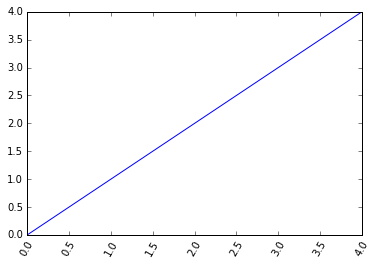

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1)

ax.plot(np.arange(5))

for x_ticklabel in ax.get_xticklabels():
    x_ticklabel.set_rotation(60)

CONNECTED TO WIND TUNNEL PRODUCTION DATABASE
Are you sure you want to connect to the production database [y or n]?y


/Users/rkp/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


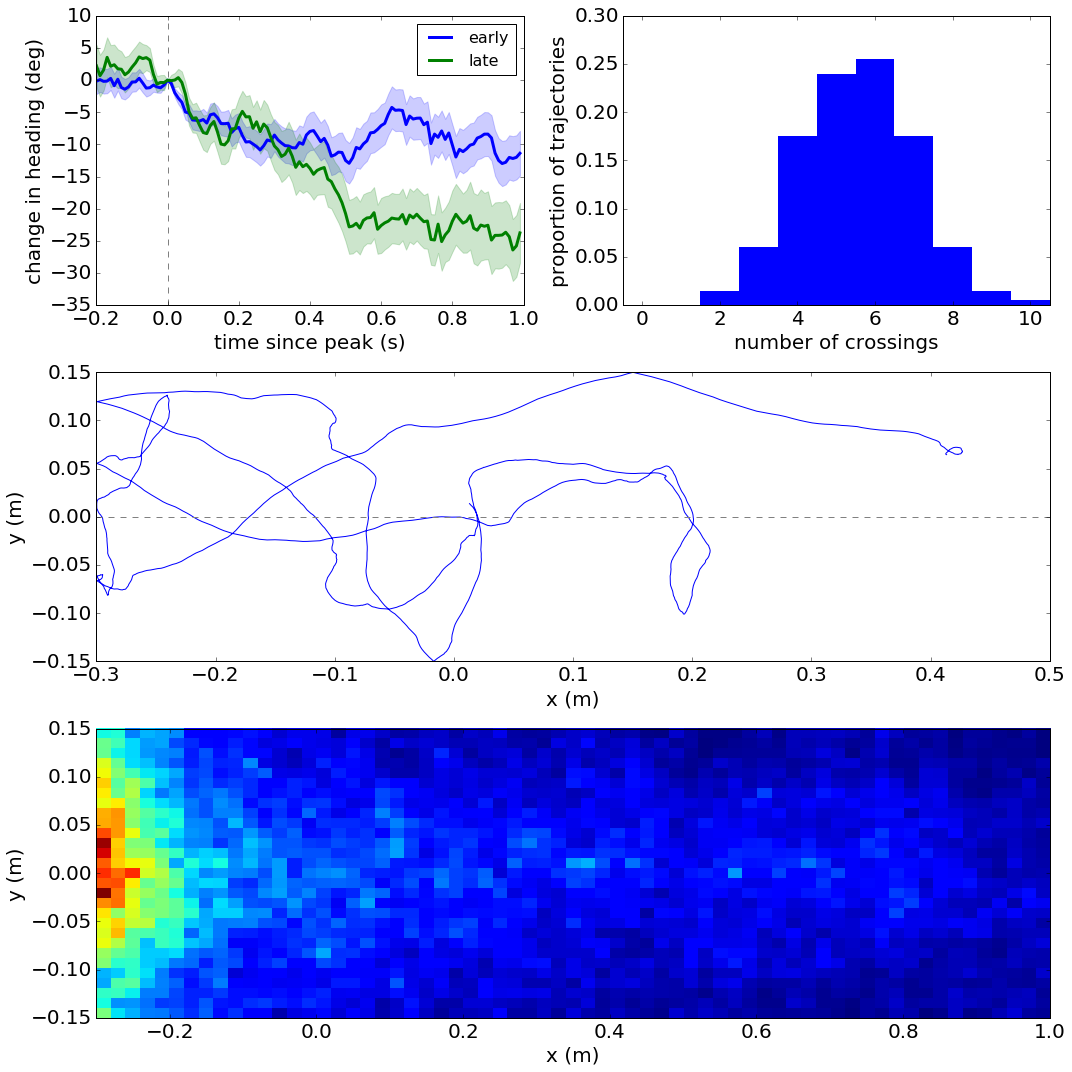

In [1]:
%matplotlib inline
import numpy as np
from view.figures.simple_tracking_analysis import crossing_triggered_headings_early_late

fig = crossing_triggered_headings_early_late(
    SEED=0, N_TRAJS=200,
    
    DURATION=15,
    DT=0.01,
    TAU=0.573219802614,
    NOISE=1.63018598472,
    BIAS=0.172212877199,
    AGENT_THRESHOLD=10,
    HIT_INFLUENCE=1,
    TAU_MEMORY=np.inf,
    K_0=9, K_S=4,
    BOUNDS=[(-0.3, 1), (-0.15, 0.15), (-0.15, 0.15)],
    
    PL_CONC=195,
    PL_MEAN=np.array([0., 0]),
    PL_STD=np.array([0.0139, 0.024]),
    
    ANALYSIS_THRESHOLD=10, H_MIN_PEAK=60, H_MAX_PEAK=120, X_MIN_PEAK=0., X_MAX_PEAK=0.7,
    EARLY_LESS_THAN=3,
    SUBTRACT_PEAK_HEADING=True, T_BEFORE=0.2, T_AFTER=1.)

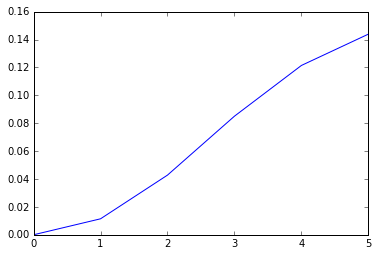

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

k_0 = (10 * np.eye(2)) ** 2
k_0_inv = np.linalg.inv(k_0)
k_s = (2 * np.eye(2)) ** 2
k_s_inv = np.linalg.inv(k_s)

b = 0.17

def b_uw(ns):
    
    certainties = []
    biases = []
    
    for n in ns:
        
        k_inv = k_0_inv + n*k_s_inv
        det_k_inv = np.linalg.det(k_inv)
        
        certainty = det_k_inv
        
        temp = np.array([1 * certainty, 1.])
        temp /= np.linalg.norm(temp)
        
        bias = temp * b
        
        biases.append(bias[0])
        
    return certainties, biases

ns = np.arange(6)

cs, bs = b_uw(ns)

plt.plot(ns, bs)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

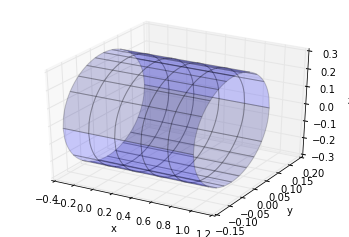

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Cylinder
y=np.linspace(-1, 1, 100)
x=np.linspace(-0.3, 1, 100)
Yc, Xc=np.meshgrid(y, x)
Zc = np.sqrt(1-Yc**2)

# Draw parameters
rstride = 20
cstride = 10
ax.plot_surface(Xc, .15 * Yc, .3 * Zc, alpha=0.2, rstride=rstride, cstride=cstride)
ax.plot_surface(Xc, .15 * Yc, -.3 * Zc, alpha=0.2, rstride=rstride, cstride=cstride)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

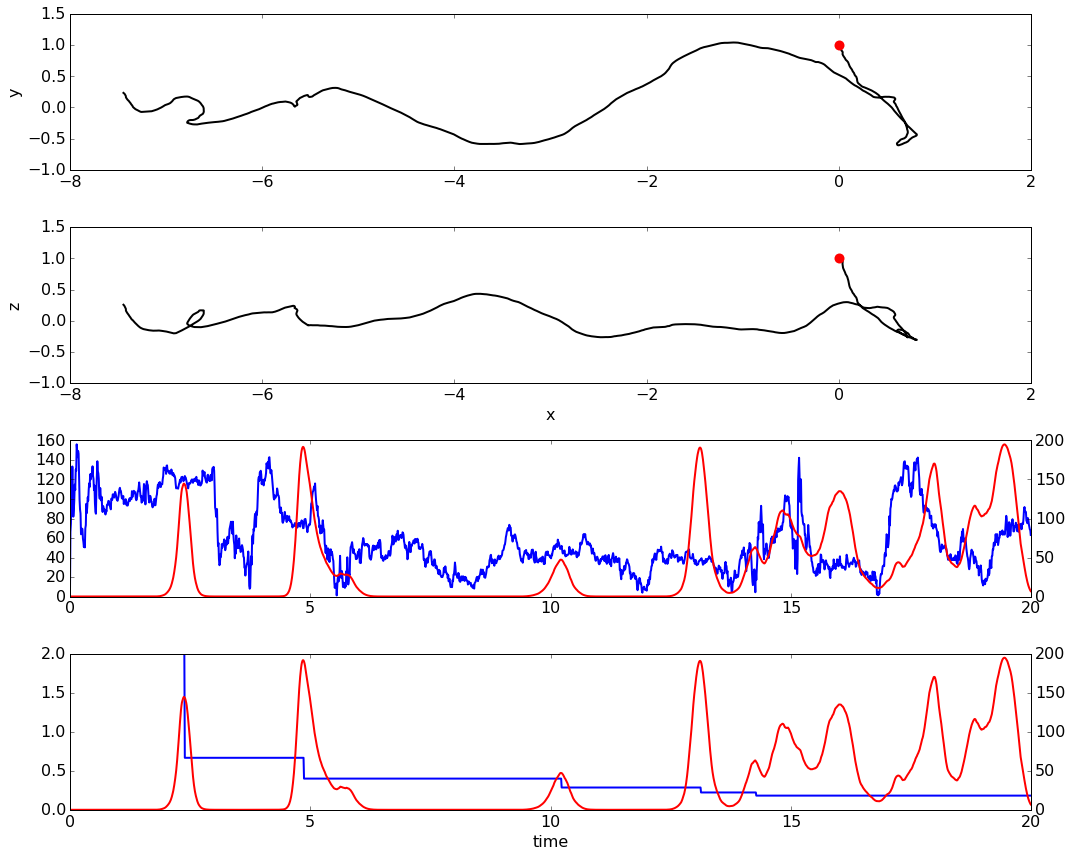

In [2]:
import pdb
%matplotlib inline
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np

import kinematics
from plot import set_font_size
import simple_tracking

pl_conc = 195
pl_mean = np.array([0., 0])
pl_k = np.array([[0.0139, 0], [0, 0.024]])

pl = simple_tracking.GaussianLaminarPlume(pl_conc, pl_mean, pl_k)

tau = 1
noise = 5.
bias = 1
hit_influence = 0.2
k_0 = np.array([[1., 0], [0, 1]])
k_s = np.array([[0.5, 0], [0, 0.5]])

threshold = 10

ag = simple_tracking.CenterlineInferringAgent(
    tau=tau, noise=noise, bias=bias, threshold=threshold,
    hit_trigger='peak', hit_influence=hit_influence, k_0=k_0, k_s=k_s)

start_pos = np.array([0., 1, 1])
duration = 20
dt = 0.01

results = ag.track(pl, start_pos=start_pos, duration=duration, dt=dt)

speeds = np.linalg.norm(results['vs'], axis=1)
headings = kinematics.heading(results['vs'])

fig, axs = plt.figure(figsize=(15, 12), tight_layout=True), []

axs.append(fig.add_subplot(4, 1, 1))
axs.append(fig.add_subplot(4, 1, 2, sharex=axs[0], sharey=axs[0]))
axs.append(fig.add_subplot(4, 1, 3))

axs[0].plot(results['xs'][:, 0], results['xs'][:, 1], color='k', lw=2, zorder=0)
axs[1].plot(results['xs'][:, 0], results['xs'][:, 2], color='k', lw=2, zorder=0)

axs[0].scatter(start_pos[0], start_pos[1], c='r', s=100, lw=0, zorder=1)
axs[1].scatter(start_pos[0], start_pos[2], c='r', s=100, lw=0, zorder=1)

axs[1].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_ylabel('z')

axs[2].plot(results['ts'], headings[:, 2], lw=2, color='b')
axs.append(axs[2].twinx())
axs[3].plot(results['ts'], results['odors'], lw=2, color='r')

axs.append(fig.add_subplot(4, 1, 4, sharex=axs[2]))

c_line_variances = np.trace(results['centerline_ks'], axis1=1, axis2=2)

axs[4].plot(results['ts'], c_line_variances, color='b', lw=2)

axs.append(axs[4].twinx())
axs[5].plot(results['ts'], results['odors'], lw=2, color='r')

axs[4].set_xlim(0, duration)

axs[4].set_xlabel('time')

for ax in axs:
    
    set_font_size(ax, 16)

In [2]:
xs = range(5)
ys = range(10, 15)
zs = range(25, 30)

for x, (y, z) in zip(xs, zip(ys, zs)):
    
    print x, y, z

ValueError: need more than 2 values to unpack

In [4]:
from itertools import product as cproduct

list(cproduct(ys, zs))

[(10, 25),
 (10, 26),
 (10, 27),
 (10, 28),
 (10, 29),
 (11, 25),
 (11, 26),
 (11, 27),
 (11, 28),
 (11, 29),
 (12, 25),
 (12, 26),
 (12, 27),
 (12, 28),
 (12, 29),
 (13, 25),
 (13, 26),
 (13, 27),
 (13, 28),
 (13, 29),
 (14, 25),
 (14, 26),
 (14, 27),
 (14, 28),
 (14, 29)]

In [6]:
x = [1,2,3]

type(x) is int

False

In [11]:
import numpy as np

np.array([-1., -3.]) / 0

/Users/rkp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


array([-inf, -inf])

In [12]:
from sklearn import linear_model

xs = np.array([
    [0, 1, 2, 3, np.nan, 5, 6, np.nan],
    [1, 0, 2.5, 3.1, np.nan, 7.2, 3.5, np.nan],
]).T

y = xs[:, 0] + xs[:, 1]

lm = linear_model.LinearRegression()

lm.fit(xs, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [14]:
x = np.arange(5)
y = -np.arange(5)
x[y < -2] = 0
import pdb; pdb.set_trace()
x *= 9
print(x)

--Return--
> <ipython-input-14-65bb9821c2db>(4)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) c
[ 0  9 18  0  0]


$$\tau \cfrac{d\mathbf{v}}{dt} = -\mathbf{v} + \eta + \mathbf{b}$$

$$p(y_c, z_c|y_{hit}, z_{hit}) \propto p(y_{hit}, z_{hit}|y_c, z_c)p(y_c, z_c)$$

$$b_{cw} \propto \textrm{unit vec towards centerline estimate} + $$
$$b_{uw} \propto 1 / det(K_{posterior})  +$$

$$move = argmin_{move} \left(E\left[\Delta S_{source}(move)\right]\right)  +$$

CONNECTED TO WIND TUNNEL PRODUCTION DATABASE
Are you sure you want to connect to the production database [y or n]?y
CONNECTED TO INFOTAXIS PRODUCTION DATABASE
Are you sure you want to connect to the production database [y or n]?y
14774 crossings for infotaxis crossing group: "wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.3mps_checkerboard_floor_odor_on_th_10_hsmoothing_3"
10532 crossings for infotaxis crossing group: "wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.4mps_checkerboard_floor_odor_on_th_10_hsmoothing_3"
1130 crossings for infotaxis crossing group: "wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.6mps_checkerboard_floor_odor_on_th_10_hsmoothing_3"


/Users/rkp/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


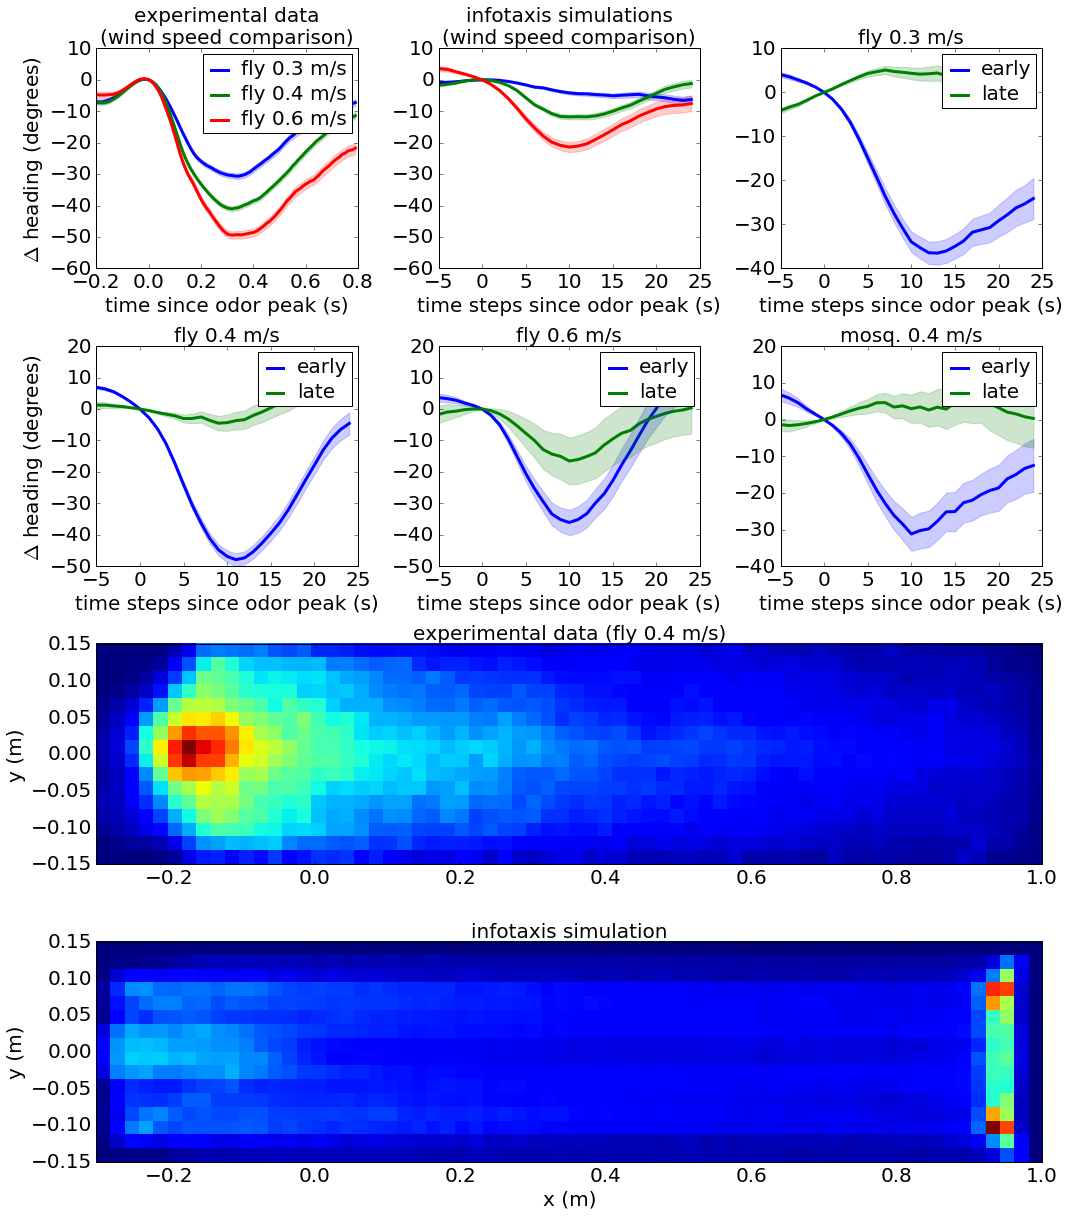

In [1]:
import pdb
%matplotlib inline
import numpy as np
from view.final_figures import infotaxis_analysis

f = infotaxis_analysis(
    WIND_TUNNEL_CG_IDS=[
        'fruitfly_0.3mps_checkerboard_floor_on_th10.0_chosen0',
        'fruitfly_0.4mps_checkerboard_floor_on_th10.0_chosen0',
        'fruitfly_0.6mps_checkerboard_floor_on_th10.0_chosen0',
        ],
    INFOTAXIS_WIND_SPEED_CG_IDS=[
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.3mps_checkerboard_floor_odor_on_th_10_hsmoothing_3',
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.4mps_checkerboard_floor_odor_on_th_10_hsmoothing_3',
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.6mps_checkerboard_floor_odor_on_th_10_hsmoothing_3',
        ],
    MAX_CROSSINGS=np.inf,
    INFOTAXIS_HISTORY_DEPENDENCE_CG_IDS=[
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.3mps_checkerboard_floor_odor_on_th_10_hsmoothing_3',
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.4mps_checkerboard_floor_odor_on_th_10_hsmoothing_3',
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.6mps_checkerboard_floor_odor_on_th_10_hsmoothing_3',
        'wind_tunnel_discretized_matched_r1000_d0.08_mosquito_0.4mps_checkerboard_floor_odor_on_th_430_hsmoothing_3',
        ],
    MAX_CROSSINGS_EARLY=2,
    X_0_MIN=0.,
    X_0_MAX=0.7,
    H_0_MIN=60,
    H_0_MAX=120,
    X_0_MIN_SIM=0,
    X_0_MAX_SIM=65,
    X_0_MIN_SIM_HISTORY=15,
    X_0_MAX_SIM_HISTORY=50,
    T_BEFORE_EXPT=0.2,
    T_AFTER_EXPT=0.8,
    TS_BEFORE_SIM=5,
    TS_AFTER_SIM=25,
    HEADING_SMOOTHING_SIM=3,
    HEAT_MAP_EXPT_ID='fruitfly_0.4mps_checkerboard_floor',
    HEAT_MAP_SIM_ID='wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.4mps_checkerboard_floor_odor_on',
    N_HEAT_MAP_TRAJS=None,
    X_BINS=np.linspace(-0.3, 1, 67, endpoint=True),
    Y_BINS=np.linspace(-0.15, 0.15, 17, endpoint=True),
    FIG_SIZE=(15, 17),
    FONT_SIZE=20,
    EXPT_LABELS={
        'fruitfly_0.3mps_checkerboard_floor_on_th10.0_chosen0': 'fly 0.3 m/s',
        'fruitfly_0.4mps_checkerboard_floor_on_th10.0_chosen0': 'fly 0.4 m/s',
        'fruitfly_0.6mps_checkerboard_floor_on_th10.0_chosen0': 'fly 0.6 m/s',
        },
    EXPT_COLORS={
        'fruitfly_0.3mps_checkerboard_floor_on_th10.0_chosen0': 'b',
        'fruitfly_0.4mps_checkerboard_floor_on_th10.0_chosen0': 'g',
        'fruitfly_0.6mps_checkerboard_floor_on_th10.0_chosen0': 'r',
        },
    SIM_LABELS={
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.3mps_checkerboard_floor_odor_on_th_10_hsmoothing_3': 'fly 0.3 m/s',
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.4mps_checkerboard_floor_odor_on_th_10_hsmoothing_3': 'fly 0.4 m/s',
        'wind_tunnel_discretized_matched_r1000_d0.08_fruitfly_0.6mps_checkerboard_floor_odor_on_th_10_hsmoothing_3': 'fly 0.6 m/s',
        'wind_tunnel_discretized_matched_r1000_d0.08_mosquito_0.4mps_checkerboard_floor_odor_on_th_430_hsmoothing_3': 'mosq. 0.4 m/s',
    })